In [10]:
import os
import zipfile
from pathlib import Path

# Define paths
dataset_folder = Path("DAT-540-PROJECT/data/leapGestRecog").expanduser()  # Adjust folder name as needed
zip_path = Path("./data/archive.zip").expanduser()

if not dataset_folder.parent.exists():
    print(f"Creating the directory: {dataset_folder.parent}")
    dataset_folder.parent.mkdir(parents=True, exist_ok=True)

# Check if dataset folder exists
if not dataset_folder.exists():
    print("Dataset not found locally. Downloading...")
    
    if not zip_path.exists():
        # Run shell command to download the dataset if it doesn't exist
        !curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/gti-upm/leapgestrecog
    
    # Unzip the downloaded file
    if zip_path.exists():
        print("Download complete. Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_folder)  # Extracts to the folder above the zip file
        print("Extraction complete.")
    else:
        print("Download failed. Please check your connection or Kaggle API credentials.")
else:
    print("Dataset already exists locally.")


Dataset not found locally. Downloading...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2180M  100 2180M    0     0  9285k      0  0:04:00  0:04:00 --:--:-- 8790k 0  8812k      0  0:04:13  0:00:11  0:04:02 9840k0  9283k      0  0:04:00  0:00:22  0:03:38 9726k    0  9241k      0  0:04:01  0:00:35  0:03:26 8910k1  0:01:17  0:02:44 8766k     0  0:03:59  0:01:26  0:02:33 9641k877M    0     0  9303k      0  0:03:59  0:01:36  0:02:23 9070k34k      0  0:03:59  0:01:52  0:02:07 9177kk      0  0:04:00  0:02:25  0:01:35 8521k 9295k      0  0:04:00  0:02:41  0:01:19 9199k9292k      0  0:04:00  0:02:52  0:01:08 9462k0  0:04:00  0:02:59  0:01:01 9479kk      0  0:04:00  0:03:01  0:00:59 9110k 9273k      0  0:04:00  0:03:06  0:00:54 9081k  0     0  9285k      0  0:04:00  0:03:24  0:00:36 9138k    0  9293k    

In [ ]:
# import cv2
# import numpy as np
# import os

# # Folder containing images
# folder_path = './data/leapGestRecog/leapGestRecog/00/01_palm/'

# # List to store image data and corresponding labels (if available)
# images = []
# labels = []  # Optional if you have labels for supervised learning

# # Iterate over the image files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         # Read each image in grayscale
#         img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        
#         # Ensure the image is not None
#         if img is not None:
#             # Flatten the 2D image into a 1D array (each pixel is a feature)
#             img_flattened = img.flatten()  # This converts the image to a 1D array
#             images.append(img_flattened)
            
#             # Example: if you have labels for supervised learning, you could store them
#             # labels.append(label)  # e.g., label = 0 or 1 for gesture class

# # Convert images list into a NumPy array (2D array, where each row is an image)
# X = np.array(images)
# # If labels exist, convert them to a NumPy array as well
# # y = np.array(labels)

# print("Shape of image data:", X.shape)


In [22]:
import cv2
import numpy as np
import os



# Resize images to a common size (128x128)
desired_size = (128, 128)


# initialize the list of images and labels
images = []
labels = []

# We only want to work with the first person's data for now (folder '00')
base_folder = './data/leapGestRecog/leapGestRecog/00/'

if os.path.isdir(base_folder):
    # for each gesture folder
    for gesture_folder in os.listdir(base_folder):
        gesture_path = os.path.join(base_folder, gesture_folder)
        
        # Check if it's a directory
        if os.path.isdir(gesture_path):
            
            # Use gesture folder as label
            label = gesture_folder 
            
            # for each image in the gesture folder
            for filename in os.listdir(gesture_path):
                
                # Check if the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    
                    # Read the image, convert to grayscale, resize, and normalize
                    img = cv2.imread(os.path.join(gesture_path, filename), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                    
                        img_resized = cv2.resize(img, desired_size)
                        img_normalized = img_resized.astype('float32') / 255.0
                        images.append(img_normalized)
                        labels.append(label)

In [23]:
from sklearn.preprocessing import LabelEncoder

#Convert labels to integers (i.e. convert '01_palm' to 1)
le = LabelEncoder()
y = le.fit_transform(labels)

In [21]:
import matplotlib.pyplot as plt

# Display sample images from each class
classes = np.unique(y)
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    idx = y.tolist().index(cls)
    axes[i].imshow(images[idx], cmap='gray')
    axes[i].set_title(f"Class: {le.inverse_transform([cls])[0]}")
    axes[i].axis('off')
plt.show()


ValueError: Number of columns must be a positive integer, not 0

<Figure size 1500x500 with 0 Axes>

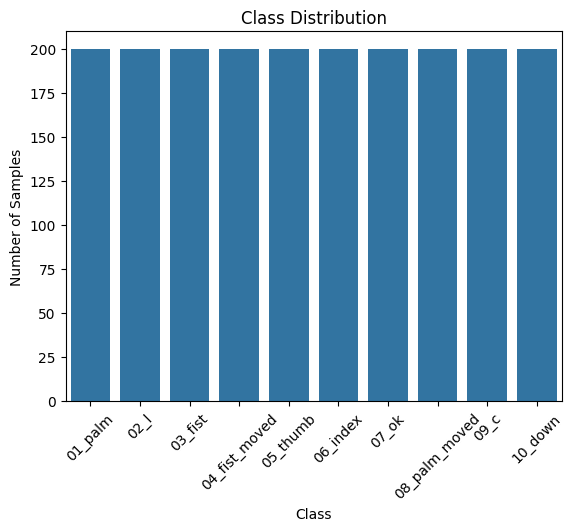

In [ ]:
import seaborn as sns

# Plot the distribution of classes, we can see that the classes are balanced
sns.countplot(x=y)
plt.xlabel('Class')
plt.xticks(ticks=classes, labels=le.inverse_transform(classes), rotation=45)
plt.ylabel('Number of Samples')''
plt.title('Class Distribution')
plt.show()


In [12]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Prepare data
# X here is a 4D array (number of samples, height, width, channels)
# which we can directly use in a Conv2D layer in the next code block
X = np.array(images).reshape(-1, desired_size[0], desired_size[1], 1)  # Add channel dimension

# Convert labels to one-hot encoded vectors
y_categorical = to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Build the CNN model
# The type of CNN we will use is a Sequential model which is
# a linear stack of layers. We will add convolutional, pooling,
# and dense layers to this model.
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(desired_size[0], desired_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Fit the model with validation
# history here is a history object that contains the loss and accuracy values during training
# which we can use to plot the training and validation loss and accuracy

#TODO: Tune these hyper parameters
#Hyper parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# See below how the loss improves and the accuracy increases (by a lot) over time
# This means that the training is working and the model is learning from the data


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7159 - loss: 0.9841 - val_accuracy: 0.9812 - val_loss: 0.0488
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 1.0000 - loss: 1.8229e-04 - val_accuracy: 1.0000 - val_loss: 7.8491e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 1.0000 - loss: 4.8379e-05 - val_accuracy: 1.0000 - val_loss: 9.0991e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 1.0000 - loss: 4.0142e-05 - val_accuracy: 1.0000 - val_loss: 8.0459e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 1.0000 - loss: 2.4422e-05 - val_accuracy: 1.0000 - val_loss: 7.6645e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 1.0000 - loss: 2.6706e-05 - val_accuracy: 1.0000 - val_loss: 7.2530e-04
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.000

In [ ]:
# Tune these hyper parameters

from tensorflow.keras.optimizers import Adam
from keras_tuner import Hyperband  

def build_model(hp):
    model = Sequential()
    
    # First Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(desired_size[0], desired_size[1], 1)
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Dense Layers with tunable dense units and dropout rate
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(len(classes), activation='softmax'))
    
    # Compile model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
from keras_tuner import Hyperband

# Define the tuner and its parameters
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuning_dir',
    project_name='hand_sign_tuning'
)

In [ ]:
# Run the tuner search
tuner.search(X_train, y_train, epochs=20, validation_split=0.1, batch_size=32)

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(f"Conv Layer 1 Filters: {best_hyperparameters.get('conv_1_filters')}")
print(f"Conv Layer 1 Kernel Size: {best_hyperparameters.get('conv_1_kernel')}")
print(f"Conv Layer 2 Filters: {best_hyperparameters.get('conv_2_filters')}")
print(f"Conv Layer 2 Kernel Size: {best_hyperparameters.get('conv_2_kernel')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Dropout Rate: {best_hyperparameters.get('dropout')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Convert one-hot encoded y_test back to labels
y_test_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00        36
         02_l       1.00      1.00      1.00        47
      03_fist       1.00      1.00      1.00        46
04_fist_moved       1.00      1.00      1.00        36
     05_thumb       1.00      1.00      1.00        34
     06_index       1.00      1.00      1.00        34
        07_ok       1.00      1.00      1.00        33
08_palm_moved       1.00      1.00      1.00        44
         09_c       1.00      1.00      1.00        48
      10_down       1.00      1.00      1.00        42

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400



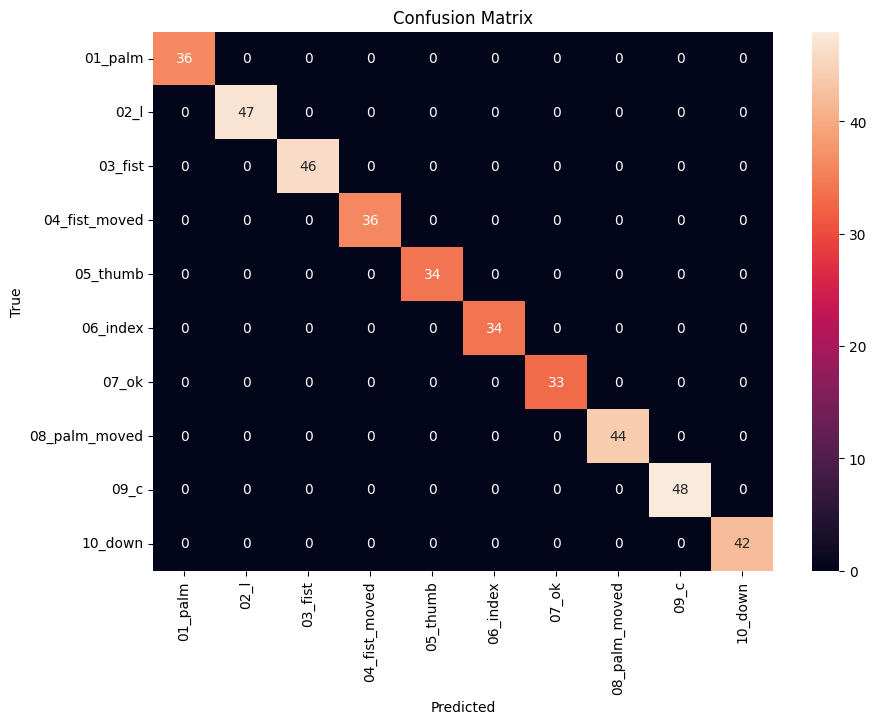

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Shows actual (y-axis) vs predicted values (x-axis)
#The diagonal represents the correct predictions
#The diagonal shows that the model never predicts false positives



In [ ]:
#Save the model
model.save('gesture_recognition_model.h5')

In [ ]:
#TODO: Cross validation
# Cross validation is a technique used to evaluate the performance of a model
# on a limited data sample. It is used to estimate how the model will perform
# in a general setting. The idea is to split the data into multiple folds
# and train the model on all but one fold and test on the remaining fold.

# This can be implemented using the KFold class from scikit-learn.

In [ ]:
#TODO: Data augmentation
# Data augmentation is a technique to artificially create new training data from existing training data.
# This is done by applying random (but realistic) transformations to the existing data.
# For example, you can rotate, flip, zoom in, or change the brightness of an image.
# This can help the model generalize better to new, unseen data.
# Keras provides a built-in ImageDataGenerator class that can be used for data augmentation.


In [ ]:
# If our use case is to be able to recognize gestures in real-time, then a step we need to take is to  
# access the webcam and use the model to make predictions on the video stream.

# TODO: Acess the webcam
# To access the webcam, we can use the OpenCV library which provides
# a VideoCapture class to capture video from the webcam.

In [ ]:
#TODO: Make predictions on the video stream from the webcam
# This is something we can use in our presentation of the project
